# PUC Minas
## Pós Graduação em Ciência de Dados e Big Data (2018-2019)
## Trabalho de Conclusão de Curso
### Aluno: Igor Ribeiro Braga

Este notebook é relativo ao meu Trabalho de Conclusão de Curso em Ciência de Dados e Big Data. O título é **Séries Temporais de Receitas Orçamentárias da Prefeitura Municipal de João Pessoa e Predição de Valores Orçamentários**, neste trabalho o dataset foi baixado no site do [TCE-PB](http://tce.pb.gov.br/servicos/dados-abertos-do-sagres-tce-pb), especificamente a Tabela: Receita Orçamentária da Esfera Municipal. Para fazer o download diretamente, clique [aqui](https://dados.tce.pb.gov.br/TCE-PB-SAGRES-Receita_Orcamentaria_Esfera_Municipal.txt.gz). O dataset deve ser salvo na pasta `datasets` na pasta raiz deste notebook.

### Leitura dos dados e importação das bibliotecas utilizadas

Para iniciar o trabalho, o primeiro passo é fazer o downlad do *dataset* com os links disponibilizados acima e armazená-lo na pasta `datasets`. Assim, o documento pode ser lido sem maiores problemas.

No código abaixo, as importações das bibliotecas utilizadas e a definição de um método para facilitar a visualização dos valores em moeda Real (R$).

In [128]:
# Imports das bibliotecas utilizadas
import locale
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller

# Define valores padrão para as figuras do matplotlib
rcParams['figure.figsize'] = 15, 6

# Função para converter Float em Currency
locale.setlocale(locale.LC_MONETARY, 'pt_BR.UTF-8')

def em_reais(valor):
    '''
    Função para exibir os valores em reais.
    '''
    return locale.currency(valor, grouping=True)

def show_value_counts(serie, column_desc=None, grain='Registers', 
                      size=None, total=None, title=None, height=10, index=None):
    '''
    Função que plota os value_counts de uma série.
    '''
    fig = plt.figure()
    fig.set_size_inches(15, height)

    ax1 = plt.subplot(1,1,1)

    serie = serie.value_counts().sort_values(ascending=True)

    if not total:
        total = serie.sum()
    
    corte = ''
    
    if (index):
        serie = serie.rename(index)
    
    if serie.index.dtype != 'object':
        if serie.index.dtype == 'float64':
            serie.index = serie.index.map(int)
        serie.index = serie.index.map(str)
    serie.index = serie.index.map(str)
    
    if size and len(serie) > size:
        serie = serie.sort_values(ascending=False)
        serie = serie[:size]
        serie = serie.sort_values(ascending=True)
        corte = ' ({} most frequents)'.format(size)
    
    if not title:
        if column_desc:
            column = column_desc
        else:
            column = serie.name
        title = "#{} by {}{}".format(grain, column, corte)
   
    ax1.barh(serie.index, serie, align='center', color='c', ecolor='black')
    percentage = serie/total*100
    number_distance = serie.max()*0.005
    
    for i, v in enumerate(serie):
        pct = locale.format('%.2f', percentage[i], True)
        ax1.text(v+number_distance , i-0.2, '{0:,} ({1}%)'.format(v, pct), color='k')
    ax1.set(title=title,
           xlabel='',
           ylabel='')
    sns.despine(left=True, bottom=True)

    plt.show()
    plt.show()

def teste_adf(serie):
    result = adfuller(serie)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


Para a leitura do dataset, foi definido os tipos das colunas **cd_ugestora**, **dt_mesano** e **dt_ano**.

In [46]:
# Definindo tipos das colunas antes de ler o dataset
columns_types = {'cd_ugestora': str, 'dt_mesano': str, 'dt_ano': int}

# Carrega os dados usando pandas
receitas = pd.read_csv('datasets/TCE-PB-SAGRES-Receita_Orcamentaria_Esfera_Municipal.txt',sep='|',dtype=columns_types,encoding='utf-8')

O dataset possui os dados de todas as entidade públicas da esfera municipal do estado da Paraíba, mas este estudo, apenas a **Prefeitura Municipal de João Pessoa** será utilizada. Portanto um filtro é aplicado e cria-se um novo Pandas Dataframe.

In [47]:
# Obtém todos os dados da Prefeitura Municipal de João Pessoa (cd_ugestora=201095)
pref_mun_joao_pessoa = receitas[receitas['cd_ugestora'] == '201095']

# Mostra informações sobre o dataset
pref_mun_joao_pessoa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7712 entries, 486833 to 754495
Data columns (total 9 columns):
cd_ugestora              7712 non-null object
de_ugestora              7712 non-null object
dt_ano                   7712 non-null int64
cd_receitaorcug          7712 non-null int64
de_receitaorcug          7516 non-null object
tp_atualizacaoreceita    7712 non-null int64
de_atualizacaoreceita    7712 non-null object
vl_lancamentoOrc         7712 non-null float64
dt_mesano                7712 non-null object
dtypes: float64(1), int64(3), object(5)
memory usage: 602.5+ KB


Acima, um resumo do dataset disponibilizado pelo Pandas. Nele, podemos verificar quais as colunas presentes, qual o tipo de dado cada coluna foi carregada e quantos objetos não nulos temos por coluna. Neste exemplo podemos verificar que a coluna **de_receitaorcug** possui valores nulos.

In [48]:
# Descrição do dataset
pref_mun_joao_pessoa.describe()

,dt_ano,cd_receitaorcug,tp_atualizacaoreceita,vl_lancamentoOrc
count,7712.000000,7.712000e+03,7712.000000,7.712000e+03
mean,2010.337915,1.514149e+08,1.196966,2.400637e+06
std,4.931977,1.116424e+09,0.594119,5.496038e+06
min,2003.000000,1.000000e+00,1.000000,0.000000e+00
25%,2006.000000,1.121250e+07,1.000000,2.645316e+04
50%,2010.000000,1.721010e+07,1.000000,2.672748e+05
75%,2015.000000,1.761000e+07,1.000000,1.587541e+06
max,2019.000000,9.517214e+09,5.000000,8.593407e+07


Com o método *describe* do Pandas obtemos informações sobre o dataset como:
1. count: Quantidade de registros
1. mean: Mediana
1. std: Desvio padrão
1. min: Valor mínimo
1. 25%: Primeiro quartil
1. 50%: Segundo quartil
1. 75%: Terceiro quartil
1. máx: Valor máximo

Abaixo são demonstrados quais são os tipos de receitas que uma prefeitura como a de João Pessoa recebe por mês.

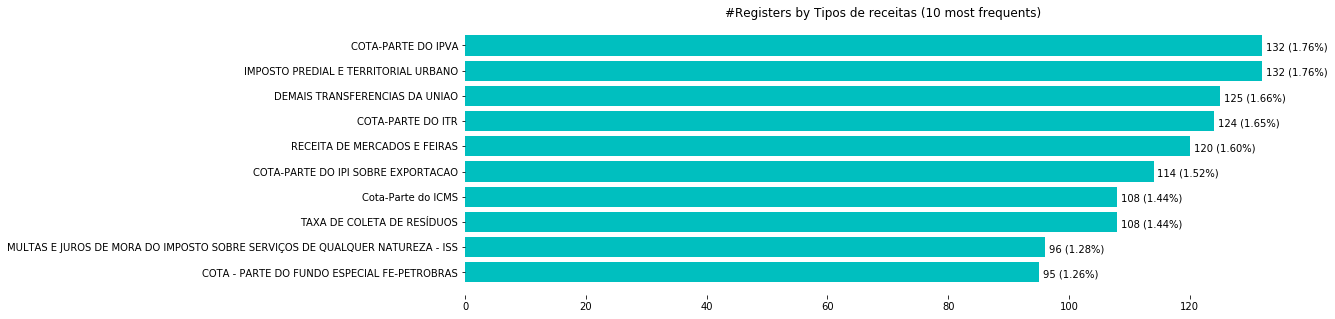

In [49]:
# Mostrar os tipos de receitas que o Município recebe.
# Aqui, os valores não são referentes ao total em receita, mas quantas vezes aparece no dataset.
show_value_counts(pref_mun_joao_pessoa['de_receitaorcug'],size=10,column_desc='Tipos de receitas',height=5)

Para o estudo, as entradas cujo o ano seja de 2019 serão descartadas, pois iremos trabalhar com os anos fechados de receitas recebidas. Para isso os índices das linhas que possuem o ano de 2019 são selecionadas para serem removidas do Dataframe.

In [50]:
# Seleção dos índices
indexAno2019 = pref_mun_joao_pessoa[pref_mun_joao_pessoa['dt_ano'] == 2019].index

# Remoção do Dataframe
pref_mun_joao_pessoa = pref_mun_joao_pessoa.drop(index=indexAno2019)
pref_mun_joao_pessoa.head()

,cd_ugestora,de_ugestora,dt_ano,cd_receitaorcug,de_receitaorcug,tp_atualizacaoreceita,de_atualizacaoreceita,vl_lancamentoOrc,dt_mesano
486833,201095,Prefeitura Municipal de João Pessoa,2004,11120800,"IMPOSTO SOBRE TRANSMISSAO -""INTER VIVOS"" DE BE...",1,Lançamento de receita,702074.41,012004
486834,201095,Prefeitura Municipal de João Pessoa,2004,11120800,"IMPOSTO SOBRE TRANSMISSAO -""INTER VIVOS"" DE BE...",1,Lançamento de receita,495731.36,022004
486835,201095,Prefeitura Municipal de João Pessoa,2004,11120800,"IMPOSTO SOBRE TRANSMISSAO -""INTER VIVOS"" DE BE...",1,Lançamento de receita,684563.07,032004
486836,201095,Prefeitura Municipal de João Pessoa,2004,11120800,"IMPOSTO SOBRE TRANSMISSAO -""INTER VIVOS"" DE BE...",1,Lançamento de receita,504136.72,042004
486837,201095,Prefeitura Municipal de João Pessoa,2004,11120800,"IMPOSTO SOBRE TRANSMISSAO -""INTER VIVOS"" DE BE...",1,Lançamento de receita,580640.06,052004


Após isso, é verificado se o dataset possui colunas com dados nulos, o que não ocorre no nosso caso.

In [51]:
# Identificando valores Nulos em colunas
pref_mun_joao_pessoa.isna().any()

cd_ugestora              False
de_ugestora              False
dt_ano                   False
cd_receitaorcug          False
de_receitaorcug          False
tp_atualizacaoreceita    False
de_atualizacaoreceita    False
vl_lancamentoOrc         False
dt_mesano                False
dtype: bool

Analisando outras entidade públicas no dataset, identiquei que algumas delas possuiam datas com meses incoerentes, como `13` por exemplo. Assim, vou verificar na coluna **dt_mesano** e pegar os 2 primeiros dígitos do meses (formato MMYYYY) e listar para verificar se algum possui esse dado incoerente.

In [52]:
# Certificando se possuem meses incoerentes
pref_mun_joao_pessoa.dt_mesano.str.slice(0,2).value_counts()

12    673
07    646
08    638
10    637
06    634
11    630
05    626
09    626
04    618
01    605
03    604
02    579
Name: dt_mesano, dtype: int64

Nesse caso os dados só possuem valores de meses válidos.

Sabendo que os dados da coluna **dt_mesano** estão coerentes, vou mudar o tipo de dado da coluna pata `datetime`.

In [53]:
# Convertendo a coluna Mês/Ano em Datetime
pref_mun_joao_pessoa['dt_mesano'] = pd.to_datetime(pref_mun_joao_pessoa['dt_mesano'], format='%m%Y')

Com o dataset suficientemente validado, podemos iniciar o processo de análise dos dados.

### Análise inicial do dados e obtenção de informações do dataset

Para iniciar o estudo do dataset, alguns questionamentos vieram a mente:

1. Quais os valores recebidos por ano?
1. Quais os valores recebidos por mês/ano?
1. Quais são as top 5 tipos de receita que mais geram receita ao Município?
1. Como se comporta a série temporal do total de receitas mês/ano do Município (2003-2018)?
1. Como se fazer forecasting de valores orçamentários baseados no dataset?
1. Utilizando o Prophet do Facebook para gerar predições da série temporal

Bem, vamos começar pela primeira pergunta:

#### 1. Quais os valores recebidos por ano?

Para responder a essa pergunta, vamos primeiro remover as colunas que não agregam informação para isso em um novo Dataframe.

In [54]:
# Criar novo dataframe apenas com os dados que importam
receitas_por_ano = pref_mun_joao_pessoa.drop(columns=['cd_ugestora','de_ugestora','cd_receitaorcug','de_receitaorcug','tp_atualizacaoreceita','de_atualizacaoreceita','dt_mesano'])
receitas_por_ano.head()

,dt_ano,vl_lancamentoOrc
486833,2004,702074.41
486834,2004,495731.36
486835,2004,684563.07
486836,2004,504136.72
486837,2004,580640.06


Aqui temos as várias entradas de receitas por mês dos anos de 2003 a 2018. No momento, queremos esses valores agrupados e somados por ano.

In [55]:
# Agrupar e calcular a soma da coluna vl_lancamentoOrc
receitas_por_ano['total'] = receitas_por_ano.groupby('dt_ano').transform('sum')
receitas_por_ano = receitas_por_ano.drop(columns=['vl_lancamentoOrc'])

In [56]:
# Removendo duplicatas e ordenando pelo ano
receitas_por_ano.drop_duplicates(keep='first', inplace=True)
receitas_por_ano.sort_values(by=['dt_ano'],ascending=True,inplace=True)

In [57]:
# Definindo o ano como índice
receitas_por_ano.set_index('dt_ano',inplace=True)
receitas_por_ano.head()

,total
dt_ano,
2003,4.269491e+08
2004,5.309502e+08
2005,6.393762e+08
2006,7.121140e+08
2007,8.121067e+08


Agora podemos exibir o primeiro gráfico, o de totais de receitas por ano.

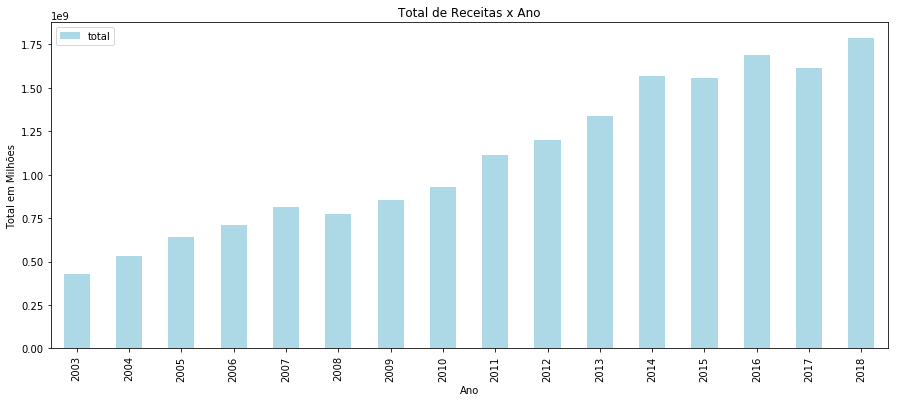

In [58]:
# Plotando gráfico: Total de recebimentos x Ano
ax = receitas_por_ano.plot(kind='bar',color='lightblue',title='Total de Receitas x Ano')

ax.set_ylabel('Total em Milhões')
ax.set_xlabel('Ano')

plt.show()

Como demonstrado no gráfico acima, o ano de 2018 foi o ano que mais acumulou receitas desde 2003. Abaixo temos um resumo de informações sobre o dados do agrupamento desses valores, como os quartis(25%, 50% e 75%), a média (mean), o desvio padrão (std) e os valores máximos e mínimos.

Mais abaixo, temos um gráfico bloxplot que evidencia essas informação graficamente.

In [59]:
# Informações sobre o desvio padrão, valores máximo e mínimo e os percentiles.
receitas_por_ano.describe()

,total
count,1.600000e+01
mean,1.096098e+09
std,4.466808e+08
min,4.269491e+08
25%,7.600471e+08
50%,1.019998e+09
75%,1.559869e+09
max,1.787108e+09


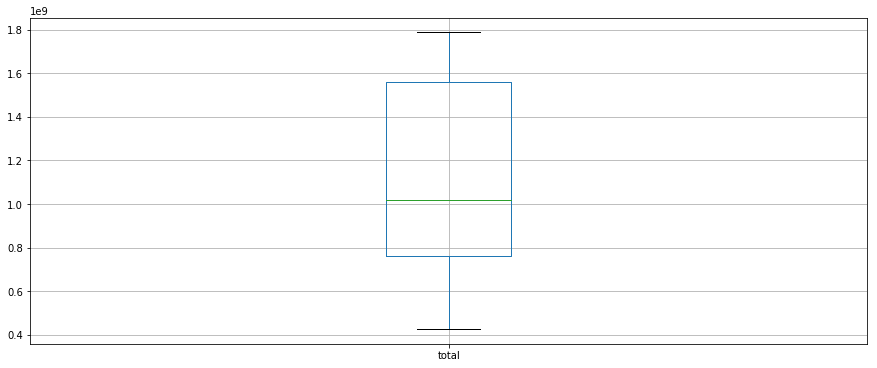

In [60]:
# Gráfico bolxplot dos totais de receitas recebidas entre os anos de 2003 e 2018
receitas_por_ano.boxplot()

In [61]:
# Ano que ocorreu o maior valor total de receitas
receitas_por_ano.idxmax(axis=0)

total    2018
dtype: int64

In [62]:
# Maior valor total de receitas recebidos em um mesmo ano
em_reais(receitas_por_ano.loc[2018]['total'])

'R$ 1.787.107.723,33'

Com o gráfico fica mais evidente a proporção dos valores recebidos por ano, e com isso pudemos identificar o ano que mais acumulou receita e o valor total acumulado.

**2018: R$ 1.787.108.000,00**

#### 2. Quais os valores recebidos por mês/ano?

A análise aqui será similar a da pergunta anterior, mas levando em consideração da coluna **dt_mesano** ao invés da **dt_ano**.

In [63]:
# Criar novo dataframe apenas com os dados que importam
receitas_por_mes_ano = pref_mun_joao_pessoa.drop(columns=['cd_ugestora','de_ugestora','cd_receitaorcug','de_receitaorcug','tp_atualizacaoreceita','de_atualizacaoreceita','dt_ano'])
receitas_por_mes_ano.head()

,vl_lancamentoOrc,dt_mesano
486833,702074.41,2004-01-01
486834,495731.36,2004-02-01
486835,684563.07,2004-03-01
486836,504136.72,2004-04-01
486837,580640.06,2004-05-01


In [64]:
# Agrupar e calcular a soma da coluna vl_lancamentoOrc
receitas_por_mes_ano['total'] = receitas_por_mes_ano.groupby('dt_mesano').transform('sum')
receitas_por_mes_ano = receitas_por_mes_ano.drop(columns=['vl_lancamentoOrc'])

In [65]:
# Removendo duplicatas
receitas_por_mes_ano.drop_duplicates(keep='first', inplace=True)
receitas_por_mes_ano.sort_values(by=['dt_mesano'],ascending=True,inplace=True)

In [66]:
# Definindo o mês/ano como índice
receitas_por_mes_ano.set_index('dt_mesano',inplace=True)
receitas_por_mes_ano.head()

,total
dt_mesano,
2003-01-01,46923205.80
2003-02-01,31463697.81
2003-03-01,34147830.15
2003-04-01,29138516.65
2003-05-01,38139457.19


Como os dados tratados aqui agora são os meses do ano, a visualização do gráfico utilizando barras não fica bom pois serão plotados os 190 meses e as informações sobre os meses no eixo X ficarão sobrepostos. Portanto vou criar um gráfico em linha. Isso também irá nos ambientar para nosso futuro estudo sobre a série temporal orçamentária.

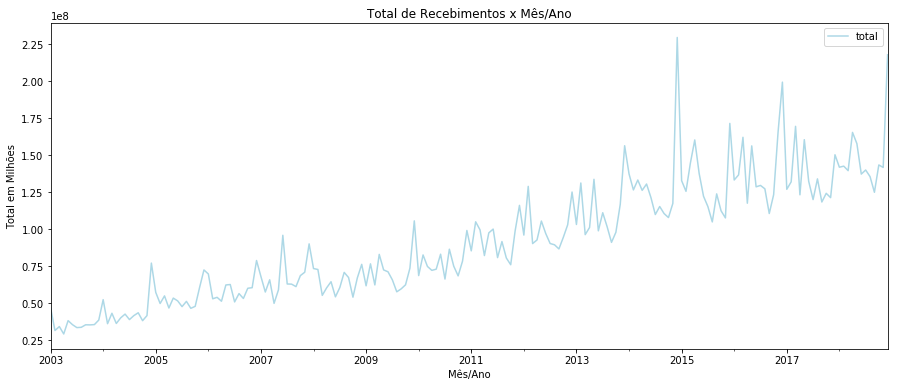

In [67]:
# Plotando gráfico: Total de recebimentos x Mês/Ano
ax = receitas_por_mes_ano.plot(kind='line',color='lightblue',title='Total de Recebimentos x Mês/Ano')

ax.set_ylabel('Total em Milhões')
ax.set_xlabel('Mês/Ano')

plt.show()

In [68]:
# Dados estatísticos
receitas_por_mes_ano.describe()

,total
count,1.920000e+02
mean,9.134154e+07
std,3.953522e+07
min,2.913852e+07
25%,6.025553e+07
50%,8.585041e+07
75%,1.231781e+08
max,2.294779e+08


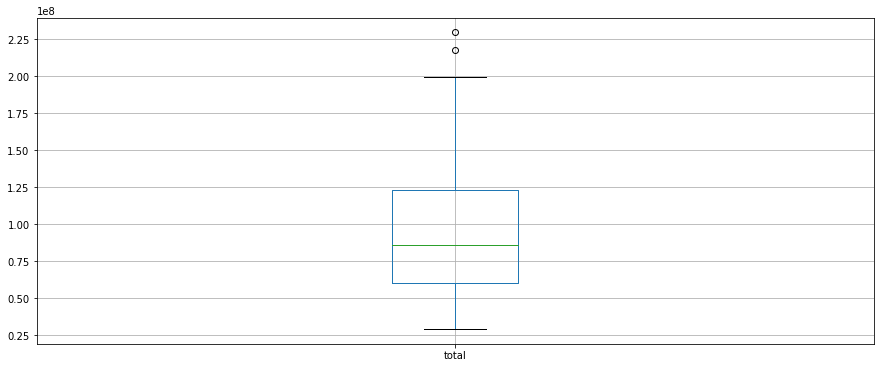

In [69]:
# Gráfico Bloxplot com os quartis, outliers, valores mínimos e máximos (desconsiderando os outliers)
receitas_por_mes_ano.boxplot()

Direfentemente do gráfico bloxpot criado com os totais por ano, neste gráfico são mostrados 2 valores considerados **outliers**. São exatamente os dois picos de valores mostrados no gráfico anterior. São os meses de dezembro de 2014 e dezembro de 2018, como evidenciados abaixo:

In [70]:
# 2 meses com maior volume de receitas
receitas_por_mes_ano.total.nlargest(n=2)

dt_mesano
2014-12-01    2.294779e+08
2018-12-01    2.177838e+08
Name: total, dtype: float64

In [71]:
# Valor formatado em reais de dezembro de 2014
em_reais(receitas_por_mes_ano.loc['2014-12-01']['total'])

'R$ 229.477.921,05'

In [72]:
# Valor formatado em reais de dezembro de 2018
em_reais(receitas_por_mes_ano.loc['2018-12-01']['total'])

'R$ 217.783.839,04'

#### 3. Quais são as top 5 tipos de receita que mais geram receita ao Município?

#### 4. Como se comporta a série temporal do total de receitas mês/ano do Município (2003-2018)?


Agora vamos iniciar nosso estudo sobre o gráfico criado apartir das receitas recebidas por mês pela Prefeitura Municipal de João Pessoa durante os anos de 2003 e 2018. A motivação é identificar no gráfico características de **Tendência, Variação e Sazonalidade**. Vejamos o gráfico abaixo:

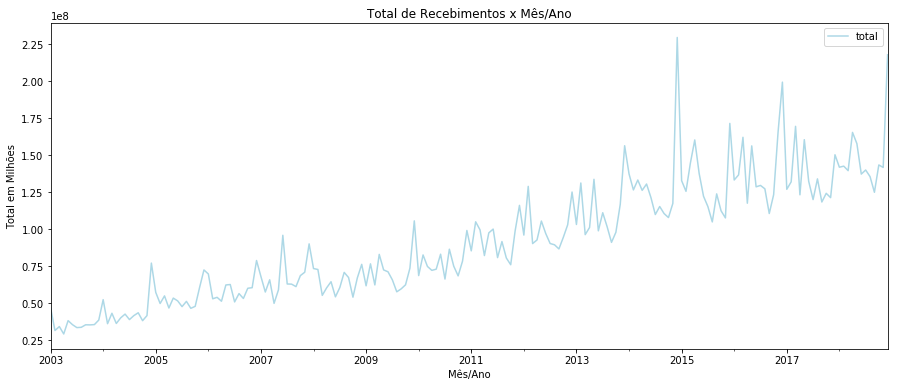

In [73]:
# Plotando gráfico: Total de recebimentos x Mês/Ano
ax = receitas_por_mes_ano.plot(kind='line',color='lightblue',title='Total de Recebimentos x Mês/Ano')

ax.set_ylabel('Total em Milhões')
ax.set_xlabel('Mês/Ano')

plt.show()

Com o passar dos anos é esperado que o volume de receitas aumente devido a reajustes nos valores cobrado pelos impostos e serviços ou até pelo aumento da população na cidade de João Pessoa. Isso é evidenciado no gráfico pela crescente curva do volume de das arrecadações, portanto podemos afirmar que esse gráfico tem uma **Tendência crescente**.  
  
A alternância dos valores (quedas e altas) presente ao longo de 1 ano nos ajuda a perceber que as arrecadações das receitas mensais variam, o que pode ser explicado devido ao fato de que alguns impostos, responsáveis por boa parte das arrecadações, são sazonais como o IPVA e IPTU. O IPVA possui uma tabela bem definida onde as arrecadações devem ser feitas respeitando os prazos baseados no final das placas dos veículos e o IPTU possuem datas limites que ficam em torno do mês de abril, evidenciando uma **sazonalidade** dos valores no gráfico. Levando em consideração esses fatos, vamos considerar que o **ciclo desta série seja anual**, ou seja, de janeiro a janeiro e confirmando a **variação** da série entre os ciclos.

##### Outliers
  
Outra questão a ser debatida aqui são os 2 outliers identificados previamente. Para isso vamos exibir o gráfico bloxplot novamente aqui.

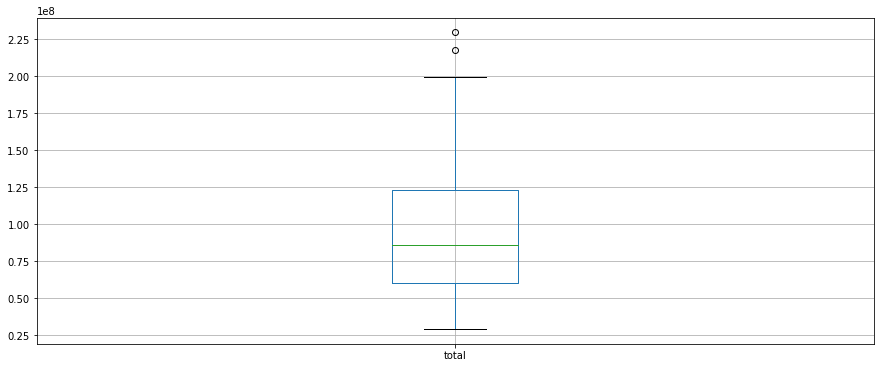

In [86]:
# Gráfico Bloxplot com os quartis, outliers, valores mínimos e máximos (desconsiderando os outliers)
receitas_por_mes_ano.boxplot()

Analisando os dados tomei a decisão de **não remover os 2 outliers** presentes aqui por 2 motivos. Primeiro o valor da distância ao terceiro percentil foi pequeno (de 2 milhões para 2.27 milhões como no gráfico) e segundo devido a natureza do meu dataset e sendo um dataset de receitas recebidas pelo município e oficializado por um órgão de competência como o Tribunal de Contas do Estado, retratando assim a veracidade dos dados.

Para comprovar que a série precisa de ajustes e que não é estacionária, podemos executar o teste de **Dickey-Fuller**, que calculará o *p-value* da série, caso o resultado seja inferior a 5% a série é dita como estacionária.

In [130]:
teste_adf(receitas_por_mes_ano.total)

ADF Statistic: -0.028282
p-value: 0.956130
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


Como o valor de *p* foi 0.9 teremos que fazer ajustes na série.

##### Variação

Para melhorar a variação da série dentro dos ciclos será aplicada o logarítmo nos valores, tornando a série mais homogênea que a anterior.

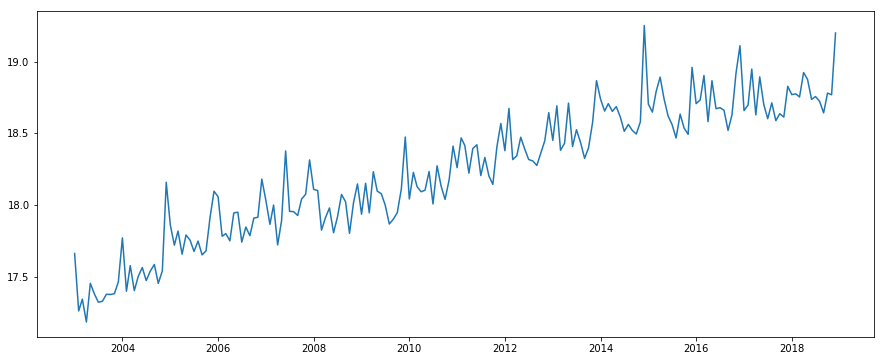

In [102]:
# Melhorando a variação
ts_log = np.log(receitas_por_mes_ano)
plt.plot(ts_log)

##### Estacionalidade e Autocorrelação

Para nos certificar da estacionalidade da séries iremos utilizar os gráficos, o ACF e o PACF.

o ACF indica se a série está estacionada.

o PACF indica se iremos fazer médias móveis e quantos níveis.

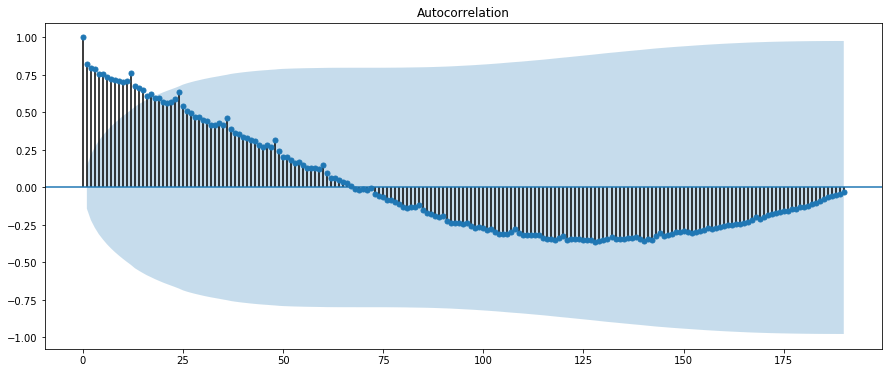

In [110]:
sm.graphics.tsa.plot_acf(receitas_por_mes_ano.values.squeeze(), lags=190)
plt.show()

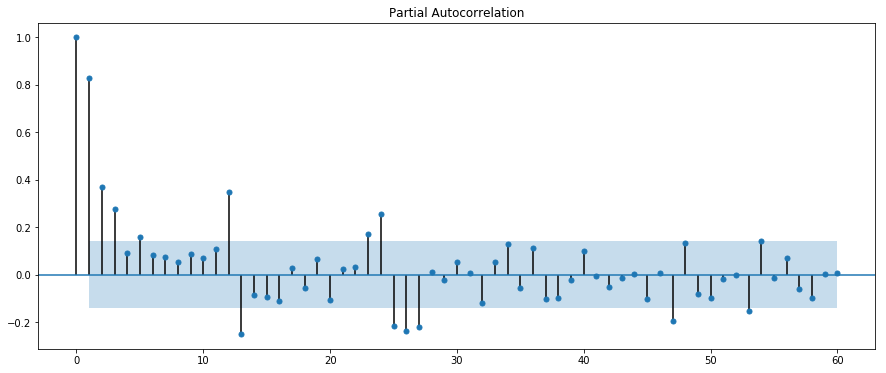

In [113]:
sm.graphics.tsa.plot_pacf(receitas_por_mes_ano.values.squeeze(), lags=60)
plt.show()

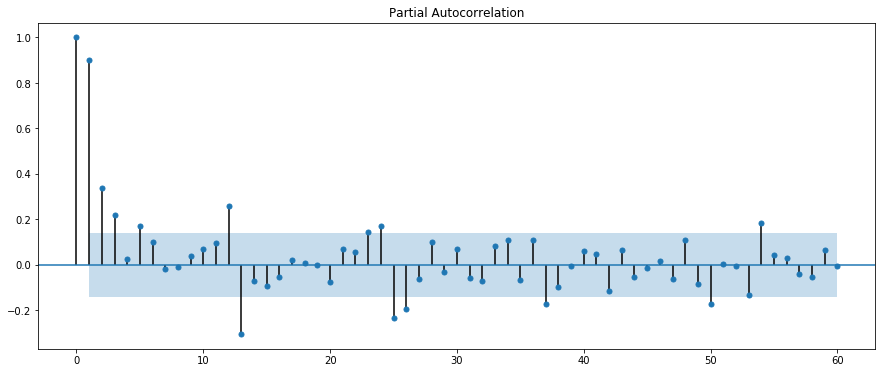

In [93]:
# Aplicando o logarítmo na séries obtemos uma autocorrelação mais controlada.
sm.graphics.tsa.plot_pacf(ts_log.values.squeeze(), lags=60)
plt.show()

##### Tornando da série estacionária por diferenciação

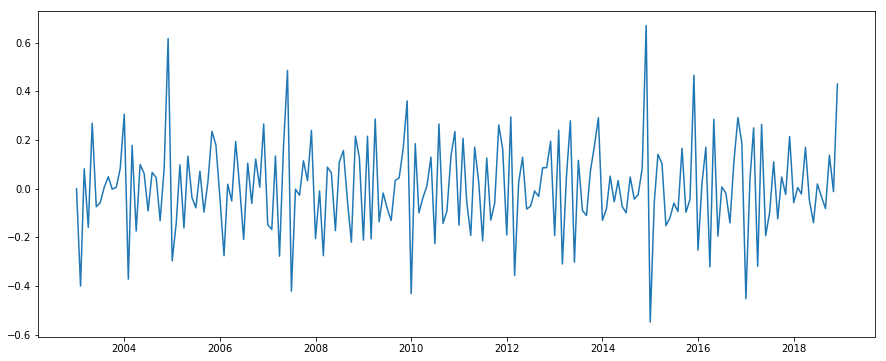

In [147]:
# Aplicando diferenciação para obter um gráfico mais estacionário
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.fillna(0, inplace=True)
plt.plot(ts_log_diff)

In [145]:
# A média dos valores da diferenciação deve tender a 0.
ts_log_diff.describe().loc['mean']

total    0.007995
Name: mean, dtype: float64

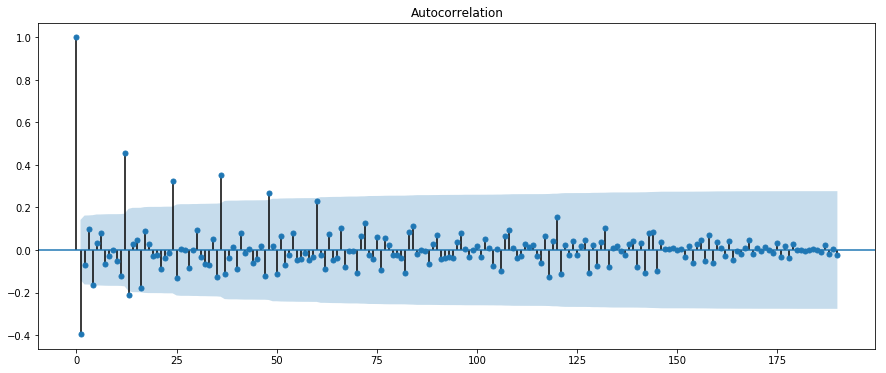

In [126]:
sm.graphics.tsa.plot_acf(ts_log_diff.values.squeeze(), lags=190)
plt.show()

In [133]:
teste_adf(ts_log_diff.total)

ADF Statistic: -12.384845
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


#### 5. Como se fazer forecasting de valores orçamentários baseados no dataset?

#### 6. Utilizando o Prophet do Facebook para gerar predições da série temporal

In [32]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

result = adfuller(np.log(np.log(receitas_por_mes_ano.total)))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.995724
p-value: 0.035296
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [33]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

result = adfuller(np.log(receitas_por_mes_ano.total))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.799238
p-value: 0.058383
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [44]:
# Plotar esse mesmo gráfico num bloxplot, plotando os ciclos
# Em R -> boxplot(AirPassengers~cycle(AirPassengers)) para ajudar a identificar a sazonalidade no ciclo.
# ACF - Auto correlation factor, mostra se o gráfico é estacionário; Se houver uma queda, ela indica se a série
# é estacionária, se ocilar não é;
# Partial ACF -> Vai mostrar os picos dentro da séria

# Testar se a nova série é estacionária, rodar o teste ADF (Augmented Dickey-Fuller Test);

# Nesse gráfico mostra
# - Uma tendência positiva, mostrando uma séria temporal crescente;
# - Isso demostra uma série não estacionária;
# - Mostra uma aparente sazonalidade com uma variação relevante nos anos de 2015 e 2017;
# - Deve-se, portanto, calcular o ruído para ver se a média dessa ocilação positiva e negativa tende a 0;
# - Seve-se também aplicar técnicas para estacionar a série;

# - Para séries não estacionárias, no modelo ARIMA, utilizar 1 no nível de autoregressão já seria o suficiente;
'''
Etapas

- Tornar a séria estacionária - Por diferenciação
- Controlar a variação (por transformação logarítmica, a mais simples)
- Determinar se os termos autorregressivos (AR) ou de médias móveis (MA) são necessários
- Teste do Modelo, Menor AIC
- Analisar os resíduos estacionários, com média zero e variância constante = Modelo correto
'''

'\nEtapas\n\n- Tornar a séria estacionária - Por diferenciação\n- Controlar a variação (por transformação logarítmica, a mais simples)\n- Determinar se os termos autorregressivos (AR) ou de médias móveis (MA) são necessários\n- Teste do Modelo, Menor AIC\n- Analisar os resíduos estacionários, com média zero e variância constante = Modelo correto\n'